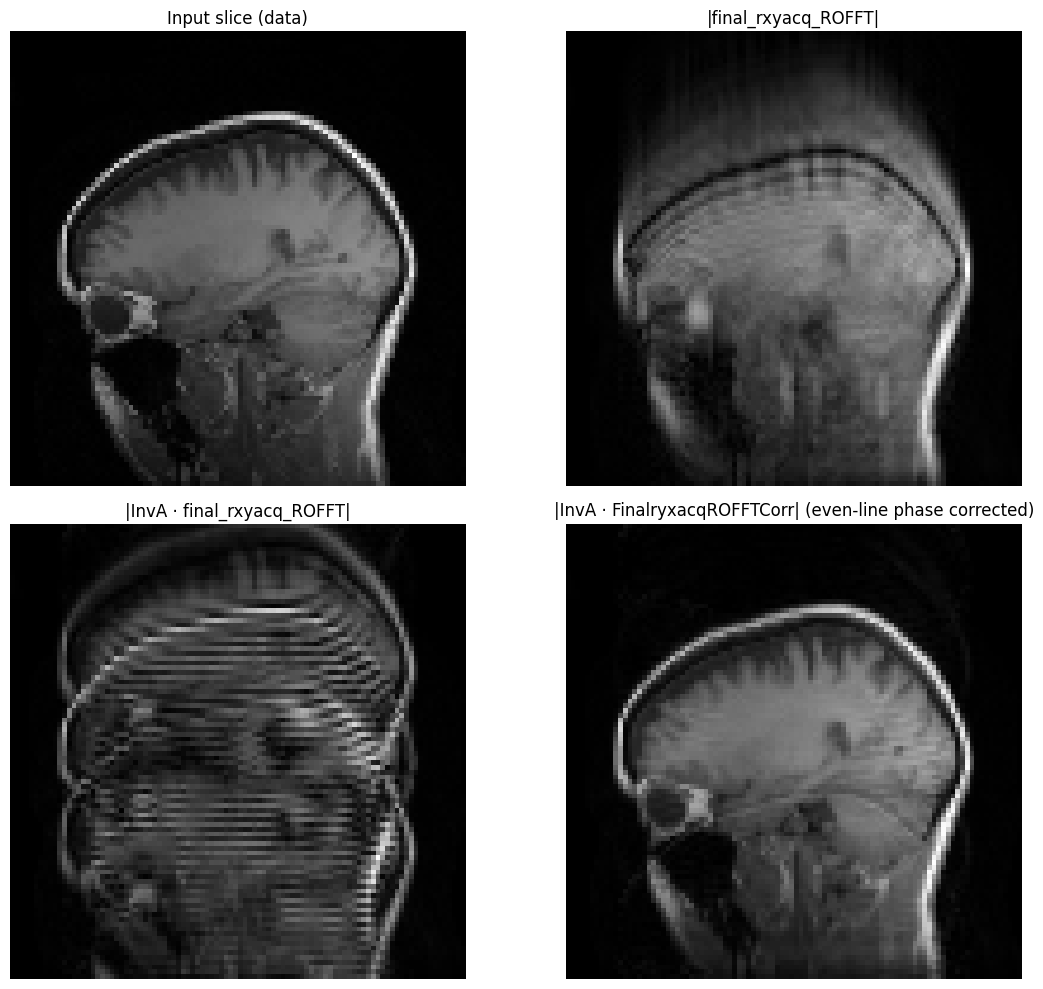

In [5]:
import os
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.io import loadmat

from sys import path
path.append("/home/data1/musong/workspace/2025/8/08-20/spenpy")
from spenpy.spen import spen

# ---------- Config ----------
root_path = "/home/data1/musong/workspace/python/spen-recons/data/IXI_sim"
idx_name  = "IXI595-IOP-1159-T1_idx0051.mat"   # single-slice filename
size      = (96, 96)                          # (w, h)

# ---------- Load saved .mat slices ----------
data_fp  = os.path.join(root_path, "hr", idx_name)
final_fp = os.path.join(root_path, "lr", idx_name)
phase_fp = os.path.join(root_path, "phase_map", idx_name)

# Each is a single slice (w, h)
data_np  = loadmat(data_fp)["hr"]                     # float32, shape (w,h)
final_np = loadmat(final_fp)["lr"]      # complex64, shape (w,h)
phase_np = loadmat(phase_fp)["phase_map"]               # float32, shape (w,h)

# Sanity check on spatial size
if data_np.shape != size or final_np.shape != size or phase_np.shape != (int(size[0] * 0.5), size[1]):
    print(f"[WARN] Loaded shapes {data_np.shape, final_np.shape, phase_np.shape} "
          f"do not match expected {size}. Proceeding with loaded shapes.")
    size = data_np.shape

# Convert to torch and add batch dim -> (1, w, h)
data_t   = torch.from_numpy(np.asarray(data_np,  dtype=np.float32)).unsqueeze(0)
final_t  = torch.from_numpy(np.asarray(final_np, dtype=np.complex64)).unsqueeze(0)
phase_t  = torch.from_numpy(np.asarray(phase_np, dtype=np.float32)).unsqueeze(0)

# ---------- Build InvA from the simulator ----------
sim = spen(acq_point=size)        # size should match the saved slice spatial size
InvA, AFinal = sim.get_InvA()     # linear operator(s) used for inversion

# ---------- Add phase problem ----------
EvenDataROFFT = final_t[:, 1::2, :].clone()                         # take even rows along w-dim
EvenDataROFFT *= torch.exp(-1j * phase_t)                           # broadcast phase (1,w,h)
FinalryxacqROFFTCorr = final_t.clone()
FinalryxacqROFFTCorr[:, 1::2, :] = EvenDataROFFT

# ---------- Reconstructions ----------
# Depending on spen.get_InvA(), matmul should support (InvA @ (b,w,h)) as in your snippet
recon_raw   = torch.matmul(InvA, final_t)               # (1,w,h) complex
recon_corr  = torch.matmul(InvA, FinalryxacqROFFTCorr)  # (1,w,h) complex

# ---------- Plot ----------
plt.figure(figsize=(12, 10))

plt.subplot(2,2,1)
plt.imshow(data_t[0].cpu().numpy(), cmap='gray')
plt.title('Input slice (data)')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(torch.abs(final_t[0]).cpu().numpy(), cmap='gray')
plt.title('|final_rxyacq_ROFFT|')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(torch.abs(recon_raw[0]).cpu().numpy(), cmap='gray')
plt.title('|InvA · final_rxyacq_ROFFT|')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(torch.abs(recon_corr[0]).cpu().numpy(), cmap='gray')
plt.title('|InvA · FinalryxacqROFFTCorr| (even-line phase corrected)')
plt.axis('off')

plt.tight_layout()
plt.show()
